<a href="https://colab.research.google.com/github/countingtls/PA_HRV_Sleep/blob/main/swell_test_3_feature_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import sklearn.pipeline
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#Read in the dataset

df_test = pd.read_csv("/content/drive/MyDrive/SWELL/hrv dataset/data/final/test.csv")
df_train = pd.read_csv("/content/drive/MyDrive/SWELL/hrv dataset/data/final/train.csv")
print(f"df_train shape{df_train.shape}")
print(f"df_test shape{df_test.shape}")

df_train shape(369289, 36)
df_test shape(41033, 36)


In [4]:
df_train.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,11.001565,...,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,2.139754,1.163485,2,no stress
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,9.170129,...,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,2.174499,1.084711,2,interruption
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,11.533417,...,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,2.135350,1.176315,2,interruption
3,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,0.133333,11.119476,...,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074,2.178341,1.179688,2,no stress
4,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,0.200000,13.590641,...,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912,2.221121,1.249612,2,no stress


In [5]:
df_train['condition'].unique()

array(['no stress', 'interruption', 'time pressure'], dtype=object)

In [6]:
#check if there is any missing value in the datasets
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369289 entries, 0 to 369288
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MEAN_RR            369289 non-null  float64
 1   MEDIAN_RR          369289 non-null  float64
 2   SDRR               369289 non-null  float64
 3   RMSSD              369289 non-null  float64
 4   SDSD               369289 non-null  float64
 5   SDRR_RMSSD         369289 non-null  float64
 6   HR                 369289 non-null  float64
 7   pNN25              369289 non-null  float64
 8   pNN50              369289 non-null  float64
 9   SD1                369289 non-null  float64
 10  SD2                369289 non-null  float64
 11  KURT               369289 non-null  float64
 12  SKEW               369289 non-null  float64
 13  MEAN_REL_RR        369289 non-null  float64
 14  MEDIAN_REL_RR      369289 non-null  float64
 15  SDRR_REL_RR        369289 non-null  float64
 16  RM

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41033 entries, 0 to 41032
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEAN_RR            41033 non-null  float64
 1   MEDIAN_RR          41033 non-null  float64
 2   SDRR               41033 non-null  float64
 3   RMSSD              41033 non-null  float64
 4   SDSD               41033 non-null  float64
 5   SDRR_RMSSD         41033 non-null  float64
 6   HR                 41033 non-null  float64
 7   pNN25              41033 non-null  float64
 8   pNN50              41033 non-null  float64
 9   SD1                41033 non-null  float64
 10  SD2                41033 non-null  float64
 11  KURT               41033 non-null  float64
 12  SKEW               41033 non-null  float64
 13  MEAN_REL_RR        41033 non-null  float64
 14  MEDIAN_REL_RR      41033 non-null  float64
 15  SDRR_REL_RR        41033 non-null  float64
 16  RMSSD_REL_RR       410

None

In [7]:
#encode the labels
df_train['condition'] = df_train['condition'].map({'no stress':0, 'interruption':1, 'time pressure':2})
df_test['condition'] = df_test['condition'].map({'no stress':0, 'interruption':1, 'time pressure':2})

In [8]:
df_train.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,11.001565,...,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,2.139754,1.163485,2,0
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,9.170129,...,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,2.174499,1.084711,2,1
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,11.533417,...,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,2.135350,1.176315,2,1
3,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,0.133333,11.119476,...,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074,2.178341,1.179688,2,0
4,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,0.200000,13.590641,...,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912,2.221121,1.249612,2,0


In [9]:
#df_train_split, df_test_split = train_test_split(df_test, test_size=0.1, random_state=None)

In [10]:
#Split the datasets into train and test
X_train, y_train, X_test, y_test = df_train.iloc[:, :-1].values, df_train.iloc[:, -1].values, df_test.iloc[:, :-1].values, df_test.iloc[:,-1].values

In [11]:
#Split the datasets into train and test
#X_train, y_train, X_test, y_test = df_train_split.iloc[:, :-1].values, df_train_split.iloc[:, -1].values, df_test_split.iloc[:, :-1].values, df_test_split.iloc[:,-1].values

In [12]:
#sScaler = StandardScaler()

In [13]:
#sScaler.fit(X_train)

In [14]:
#X_train = sScaler.transform(X_train)
#X_test = sScaler.transform(X_test)

In [15]:
SelectFeature = SelectKBest(f_classif, k=6)

In [16]:
X_train.shape

(369289, 35)

In [17]:
X_train_new = SelectFeature.fit_transform(X_train, y_train)
SelectFeature.get_support(True)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


array([0, 1, 4, 6, 7, 9])

In [18]:
SelectFeature.get_support()

array([ True,  True, False, False,  True, False,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [19]:
#3 features filters
filter = [ False,  False, True, False, False, False,  False,  False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, True,
       False, False, False, False, False, False, False, False]

In [20]:
X_train_new = X_train[:,filter]
X_train_new.shape

(369289, 3)

In [21]:
X_test_new = X_test[:,filter]
X_test_new.shape

(41033, 3)

In [22]:
print(X_train_new[0:5,:])

[[ 140.97274124 1009.24941901   15.5226025 ]
 [  81.31774203  690.11327479    2.10852542]
 [  84.49723585 1298.22261927   13.76972944]
 [  90.37053724 1005.98165918   18.18191348]
 [  62.76624216 1421.78205144   48.2158224 ]]


In [23]:
print(X_test_new[0:5,:])

[[  74.72231522  615.91457314   66.61705708]
 [  58.49942906 1566.86613534   26.50008618]
 [ 132.84911032 2074.86888397   16.02493479]
 [ 117.82209353  505.88666361   17.58147043]
 [ 143.96845749  524.20397117   35.19905393]]


In [24]:
# Random Forest Model
RFC = RandomForestClassifier(n_estimators=100, max_features='log2', n_jobs=-1)

In [25]:
RFC.fit(X_train_new, y_train)

RandomForestClassifier(max_features='log2', n_jobs=-1)

In [26]:
RFC.score(X_test_new, y_test)

0.9882777276825969

In [27]:
RFC_y_predict = RFC.predict(X_test_new)
RFC_cf=confusion_matrix(y_test, RFC_y_predict)
print(metrics.classification_report(y_test, RFC_y_predict))
print(RFC_cf)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     22158
           1       0.99      0.99      0.99     11782
           2       0.99      0.98      0.98      7093

    accuracy                           0.99     41033
   macro avg       0.99      0.99      0.99     41033
weighted avg       0.99      0.99      0.99     41033

[[21990   109    59]
 [  140 11619    23]
 [  115    35  6943]]


In [28]:
import time

start_time = time.time()
importances = RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFC.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.160 seconds


In [29]:
print(std)

[0.0386478  0.04576445 0.04535231]


['SDRR', 'LF', 'HF']


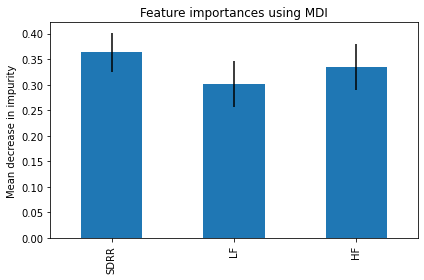

In [30]:
import matplotlib.pyplot as plt
feature_names = [f"feature {i}" for i in range(X_train_new.shape[1])]
feature_names = ["SDRR", "LF", "HF"]
print(feature_names)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [31]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(RFC, X_test_new, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 29.332 seconds


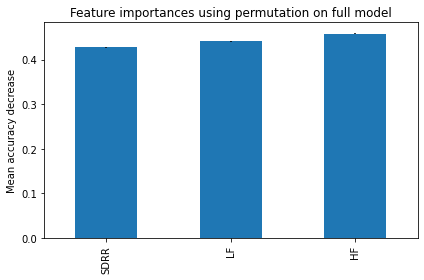

In [32]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [33]:
#Multi-layer NN model 20 hidden layers 100 nodes
MLPC = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=(20, 200), 
                     max_iter=5000, early_stopping=True, random_state=42)

In [34]:
MLPC.fit(X_train_new, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(20, 200), max_iter=5000,
              random_state=42)

In [35]:
MLPC.score(X_test_new, y_test)

0.799917139863037

In [36]:
MLPC_y_predict = MLPC.predict(X_test_new)
MLPC_cf=confusion_matrix(y_test, MLPC_y_predict)
print(metrics.classification_report(y_test, MLPC_y_predict))
print(MLPC_cf)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     22158
           1       0.81      0.75      0.78     11782
           2       0.67      0.70      0.69      7093

    accuracy                           0.80     41033
   macro avg       0.77      0.77      0.77     41033
weighted avg       0.80      0.80      0.80     41033

[[18989  1523  1646]
 [ 2139  8873   770]
 [ 1555   577  4961]]


In [37]:
# K-nn model k=10
from sklearn.neighbors import KNeighborsClassifier
KNC = KNeighborsClassifier(n_neighbors=10)
KNC.fit(X_train_new, y_train)

KNeighborsClassifier(n_neighbors=10)

In [38]:
KNC.score(X_test_new, y_test)

0.9358808763678015

In [39]:
KNC_y_predict = KNC.predict(X_test_new)
KNC_cf=confusion_matrix(y_test, KNC_y_predict)
print(metrics.classification_report(y_test, KNC_y_predict))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     22158
           1       0.94      0.92      0.93     11782
           2       0.92      0.88      0.90      7093

    accuracy                           0.94     41033
   macro avg       0.93      0.92      0.93     41033
weighted avg       0.94      0.94      0.94     41033



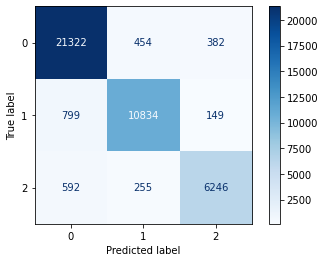

In [40]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, KNC_y_predict, display_labels=KNC.classes_, 
                                                normalize=None, cmap=plt.cm.Blues)
plt.show()

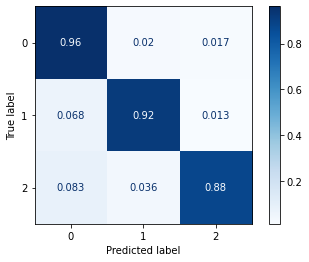

In [41]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, KNC_y_predict, display_labels=KNC.classes_, 
                                                normalize='true', cmap=plt.cm.Blues)
plt.show()

In [42]:
# K-nn model k=10
KNC = KNeighborsClassifier(n_neighbors=7)
KNC.fit(X_train_new, y_train)

KNeighborsClassifier(n_neighbors=7)

In [43]:
KNC.score(X_test_new, y_test)

0.9414861209270587

In [44]:
KNC_y_predict = KNC.predict(X_test_new)
KNC_cf=confusion_matrix(y_test, KNC_y_predict)
print(metrics.classification_report(y_test, KNC_y_predict))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     22158
           1       0.94      0.93      0.94     11782
           2       0.92      0.91      0.91      7093

    accuracy                           0.94     41033
   macro avg       0.94      0.93      0.93     41033
weighted avg       0.94      0.94      0.94     41033



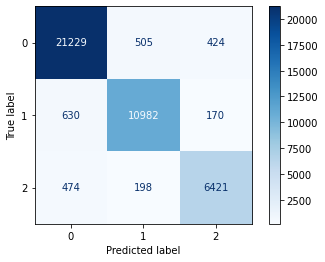

In [45]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, KNC_y_predict, display_labels=KNC.classes_, 
                                                normalize=None, cmap=plt.cm.Blues)
plt.show()

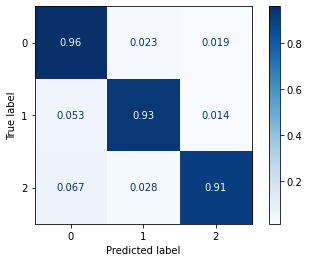

In [46]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, KNC_y_predict, display_labels=KNC.classes_, 
                                                normalize='true', cmap=plt.cm.Blues)
plt.show()